In [1]:
from cuopt import routing
import cudf
import pandas as pd
import notebook_utils.notebook_helpers as helper_map

# Service Team Routing
## Capacitated Vehicle Routing Problem with Time Windows (CVRPTW)

The ability of service providers to set service time windows allows for easier and more dependable coordination between the service provider and their customers, while increasing overall customer satisfaction.

In this scenario we have a number of service order locations with associated time windows and service times (time on-site to complete service). Each technician has an associated availability, ability to complete certain types of service, and a maximum number of service appointments per day.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 Headquarters 
        - service type 1 demand: [0]
        - service type 2 demand: [1]
        - headquarters hours of operation: [5,20]
    - 7 Service Locations
        - service type 1 demand: [1, 1, 1, 0, 0, 0, 0]
        - service type 2 demand: [0, 0, 1, 1, 1, 1, 1]
        - service locations time windows: [[9,12],[9,12],[11,14],[13,16],[13,16],[13,16],[13,16]]
        - service location service times: [ 1, 1, 1.5, 0.5, 0.5, 0.5]

- 3 Delivery vehicles each with an associated capacity
    - 3 service technicians
        - capacity for service type 1: [2, 1, 0]
        - capacity for service type 2: [0, 1, 4]
        - technician availability [[9,17], [12,15], [9,17]]


Below we visualize the service locations with respect to the service company headquarters. The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_creation.ipynb](cost_matrix_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

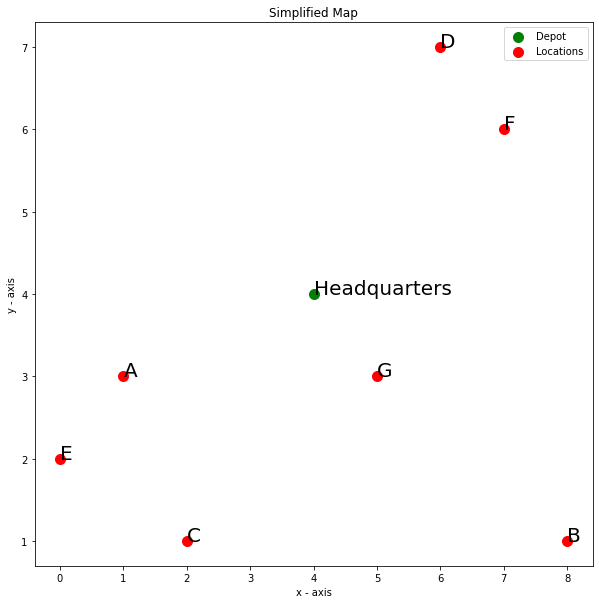

In [2]:
location_names       = [ "Headquarters",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [     [4, 4],        [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
helper_map.gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we are constraining time window constraints.  When constraining time windows for locations or vehicles it is assumed (if only a single cost matrix is provided) that it represents time. 

Here is the cost(time) matrix corresponding to the locations above:

In [3]:
time_matrix = [
 [0.00, 0.31, 0.50, 0.36, 0.36, 0.44, 0.36, 0.14],
 [0.31, 0.00, 0.72, 0.22, 0.64, 0.14, 0.67, 0.40],
 [0.50, 0.72, 0.00, 0.60, 0.63, 0.80, 0.51, 0.36],
 [0.36, 0.22, 0.60, 0.00, 0.72, 0.22, 0.70, 0.36],
 [0.36, 0.64, 0.63, 0.72, 0.00, 0.77, 0.14, 0.41],
 [0.44, 0.14, 0.80, 0.22, 0.77, 0.00, 0.80, 0.51],
 [0.36, 0.67, 0.51, 0.70, 0.14, 0.80, 0.00, 0.36],
 [0.14, 0.40, 0.36, 0.36, 0.41, 0.51, 0.36, 0.00]
]

# Create a dataframe of this matrix
time_matrix  = cudf.DataFrame(time_matrix, 
                              index=location_coordinates_df.index, 
                              columns=location_coordinates_df.index)
time_matrix

,Headquarters,A,B,C,D,E,F,G
Headquarters,0.00,0.31,0.50,0.36,0.36,0.44,0.36,0.14
A,0.31,0.00,0.72,0.22,0.64,0.14,0.67,0.40
B,0.50,0.72,0.00,0.60,0.63,0.80,0.51,0.36
C,0.36,0.22,0.60,0.00,0.72,0.22,0.70,0.36
D,0.36,0.64,0.63,0.72,0.00,0.77,0.14,0.41
E,0.44,0.14,0.80,0.22,0.77,0.00,0.80,0.51
F,0.36,0.67,0.51,0.70,0.14,0.80,0.00,0.36
G,0.14,0.40,0.36,0.36,0.41,0.51,0.36,0.00


### Service Locations

Setup the service location data

In [4]:
service_location_data = {
    "location_ids": location_names,
    "service_type1_demand": [0, 1, 1, 1, 0, 0, 0, 0],
    "service_type2_demand": [0, 0, 0, 1, 1, 1, 1, 1],
    "location_earliest_time": [5, 9, 9, 11, 13, 13, 13, 13],
    "location_latest_time": [20, 12, 12, 14, 16, 16, 16,16],
    "required_service_time": [0, 1, 1, 1.5, 0.5, 0.5, 0.5, 0.5]
}
service_location_data = cudf.DataFrame(service_location_data).set_index('location_ids')
service_location_data

,service_type1_demand,service_type2_demand,location_earliest_time,location_latest_time,required_service_time
location_ids,,,,,
Headquarters,0,0,5,20,0.0
A,1,0,9,12,1.0
B,1,0,9,12,1.0
C,1,1,11,14,1.5
D,0,1,13,16,0.5
E,0,1,13,16,0.5
F,0,1,13,16,0.5
G,0,1,13,16,0.5


### Vehicles

Setup vehicle/technician data

In [5]:
n_vehicles = 3
vehicle_data = {
    "vehicle_ids": [i for i in range(n_vehicles)],
    "capacity_service_type1":[2, 1, 0],
    "capacity_service_type2":[0, 1, 4],
    "vehicle_availability_earliest":[9, 11, 9],
    "vehicle_availability_latest":[17, 15, 17]
}
vehicle_data = cudf.DataFrame(vehicle_data).set_index('vehicle_ids')
vehicle_data

,capacity_service_type1,capacity_service_type2,vehicle_availability_earliest,vehicle_availability_latest
vehicle_ids,,,,
0,2,0,9,17
1,1,1,11,15
2,0,4,9,17


### cuOpt DataModel View

Setup the routing.DataModel.

In [6]:
n_locations = len(service_location_data)
n_vehicles = len(vehicle_data)

data_model = routing.DataModel(n_locations, n_vehicles)

# set the cost matrix
data_model.add_cost_matrix(time_matrix)

# add a capacity dimension for service type 1
data_model.add_capacity_dimension(
    "service_type1",
    cudf.Series(service_location_data["service_type1_demand"]),
    cudf.Series(vehicle_data["capacity_service_type1"])
)
# add a capacity dimension for service type 2
data_model.add_capacity_dimension(
    "service_type2",
    cudf.Series(service_location_data["service_type2_demand"]),
    cudf.Series(vehicle_data["capacity_service_type2"])
)

# add time windows and service time for the locations
data_model.set_order_time_windows(
    service_location_data["location_earliest_time"],
    service_location_data["location_latest_time"], 
    service_location_data["required_service_time"]
)

# add time windows for vehicle availability
data_model.set_vehicle_time_windows(
    vehicle_data["vehicle_availability_earliest"], 
    vehicle_data["vehicle_availability_latest"]
)

### CuOpt SolverSettings

Setup routing.SolverSettings.

In [7]:
solver_settings = routing.SolverSettings()

# set number of climbers that will try to search for an optimal routes in parallel
solver_settings.set_number_of_climbers(128)

# solver_settings will run for given time limit.  Larger and/or more complex problems may require more time.
solver_settings.set_time_limit(0.05)

### Solution

In [8]:
routing_solution = routing.Solve(data_model, solver_settings)
if routing_solution.get_status() == 0:
    print("Cost for the routing in time: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in time:  4.059999942779541
Vehicle count to complete routing:  3
For vehicle - 0 route is: 

Headquarters->A->B->Headquarters


For vehicle - 1 route is: 

Headquarters->C->Headquarters


For vehicle - 2 route is: 

Headquarters->E->G->F->D->Headquarters




**Notice** that this solution leverages the fact that vehicle 1 is the only vehicle with the ability to perform both service type 1 and service type 2.  In addition, vehicle 0 and vehicle 2 also serve the locations they are suited to service and minimize the time taken along these routes.

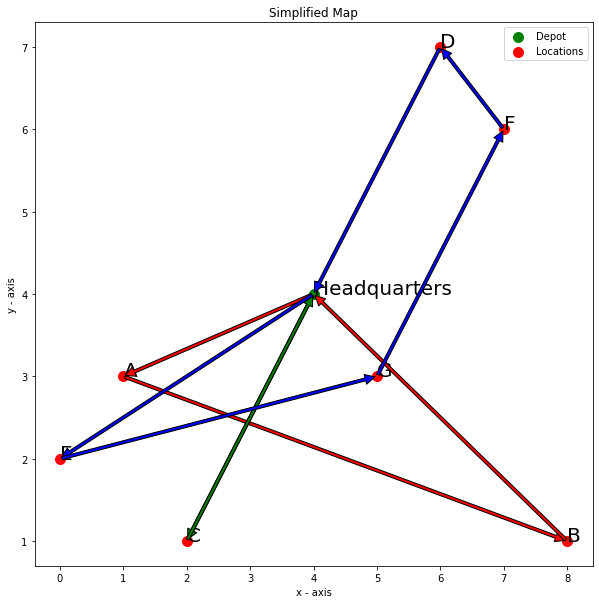

In [9]:
vehicle_colors = ["red", "green", "blue"]
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

In [10]:
# routing_solution.route

_____

####  SPDX-FileCopyrightText: Copyright (c) 2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
####  SPDX-License-Identifier: MIT

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.

---